I compare redshift success rates for $\sim 5000$ DESI-like GAMA-Legacy synthetic spectra using `redrock` with different settings. We run `redrock` with three different settings: 

1. `redrock` no flags
2. `redrock` with archetype flag
3. `redrock` with archetype flag (updated 9/25/2018) and updated redrock template 

~~3. `redrock` with archetype flag where the archetypes were constructed with strong H$\alpha$ spectra added to the training set.~~

In [1]:
import h5py 
import numpy as np 
from astropy.io import fits
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [4]:
dir_spec = UT.dat_dir()+'spectra/gamadr3_legacydr7/'
# read in gleg data
fblock = h5py.File(dir_spec+'gleg.g15.darksky.seed1.exptime300.1of13blocks.hdf5', 'r')
block = {}
for g in fblock.keys():
    block[g] = {} 
    for k in fblock[g].keys(): 
        block[g][k] = fblock[g][k].value
        
magnorm_flag = block['forwardmodel']['magnorm_flag']

# read in redrock output (w/ no archetype)
zblock1 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.fits')[1].data
# read in redrock output (w/ archetype)
zblock2 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.archetype.fits')[1].data
# read in redrock output (w/ archetype updated and updated template)
zblock3 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.uparch.uptemp.fits')[1].data

## read in redrock output (w/ updated archetype constructed using GLeg synthetic spectra)
#zblock3 = fits.open(dir_spec+'g15.synSpectra.darksky.seed1.exptime300.1of13blocks.redrock.uparchetype.fits')[1].data

In [5]:
z_true = block['gama-spec']['z']

In [6]:
def zsuccess(zrr, ztrue, zwarn): 
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    return (dz_1pz < 0.003) & (zwarn == 0)# & magnorm_flag

success1 = zsuccess(zblock1['Z'], z_true, zblock1['ZWARN'])
success2 = zsuccess(zblock2['Z'], z_true, zblock2['ZWARN'])
success3 = zsuccess(zblock3['Z'], z_true, zblock3['ZWARN'])

In [7]:
sucs = [success1, success2, success3]
lbls = [r'RR criterion $\#$1', r'RR criterion $\#$2', r'RR criterion $\#$3']
colors = ['k', 'C0', 'C1']

In [8]:
def zsuccess_rate_magnorm(prop, zsuccess_cond, magnorm_flag, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop[magnorm_flag], bins=nbins, range=range)
    hv, _ = np.histogram(prop[magnorm_flag], bins=bins, weights=prop[magnorm_flag])
    h1, _ = np.histogram(prop[zsuccess_cond & magnorm_flag], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

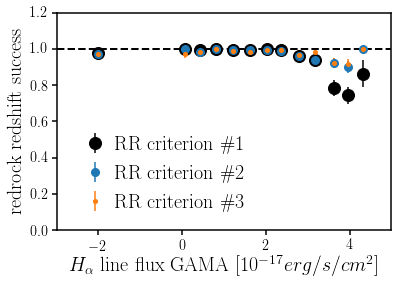

In [9]:
block_ha = block['gama-spec']['ha_flux']
hasha = (block_ha > 0.)
block_ha_lowlim = block_ha.copy()
block_ha_lowlim[~hasha] = 10**-2

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([-3., 5.], [1., 1.], c='k', ls='--', lw=2)

for isuc, suc in enumerate(sucs): 
    mm, e1, ee1 = zsuccess_rate_magnorm(np.log10(block_ha_lowlim), suc, magnorm_flag, range=[-3., 5.])
    sub.errorbar(mm, e1, ee1, c=colors[isuc], fmt='o', label=lbls[isuc], markersize=(12-isuc*4))

sub.set_xlabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_xlim([-3., 5.])
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})